---
title: Comparing Fast Enformer gene expression prediction performance 
author: Sabrina Mi
date: 1/10/2024
---

**Takeaways**

* I definitely need to parallelize if we want to test across 340 samples
    * 1 gene, 340 samples: ~ 30 seconds
    * 114 genes, 272 samples: ~ 55 minutes
* Lots of bumps trying to implement parsl
* Genes with more significantly correlated Enformer predictions tended to have significantly correlated "Fast Enformer" predictions, although not necessarily in the same direction

## Setup

**Step 1**: Import libraries

In [1]:
#| code-fold: true
#| output: false

import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
import os
import time
columns = ['POS', 'ACI', 'BN', 'BUF', 'F344', 'M520', 'MR', 'WKY', 'WN']

2024-01-24 21:17:31.863260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 21:17:38.342593: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /soft/compilers/cudatoolkit/cuda-11.8.0/extras/CUPTI/lib64:/soft/compilers/cudatoolkit/cuda-11.8.0/lib64:/soft/libraries/trt/TensorRT-8.5.2.2.Linux.x86_64-gnu.cuda-11.8.cudnn8.6/lib:/soft/libraries/nccl/nccl_2.16.2-1+cuda11.8_x86_64/lib:/soft/libraries/cudnn/cudnn-11-linux-x64-v8.6.0.163/lib:/soft/compilers/cudatoolkit/cuda-11.8.0/extras/CUPTI/lib64:/soft/compilers/cudatoolkit/cuda-11.8.0/lib64:/so

**Step 2:** Read samples, genes and define paths

In [2]:
#| code-fold: true
pred_expr = pd.read_csv("/home/s1mi/enformer_rat_data/output/Br_human_predicted_expression.csv", index_col=0)
individuals = list(pred_expr.index)
gene_annot = pd.read_csv("/eagle/AIHPC4Edu/sabrina/Br_predictions/HS_founder_epigenomes/gene_mapping.txt")
genes_df = gene_annot[gene_annot['gene'].isin(pred_expr.columns)]

**Step 3:** Define interpolation Algorithm

In [3]:
#| code-fold: true
probabilities_dir = "/home/s1mi/Br_genotype_probabilities"
reference_dir = "/eagle/AIHPC4Edu/sabrina/Br_predictions/HS_founder_epigenomes/human"
output_dir = "/eagle/AIHPC4Edu/sabrina/Br_prediction_from_founders"
run_dir = "/home/s1mi/Github/deep-learning-in-genomics/posts/2024-01-10-epigenomexcan-vs-enformer-significant-genes"

**Step 4:** Define interpolation algorithm, matrix operations, and gene looping

In [4]:
#| code-fold: true
def interpolate(x, xi, y):
    j   =   tf.argsort(tf.concat((x, xi), axis=-1))
    k   =   tf.range(len(j))
    q   =   tf.scatter_nd(j[:, tf.newaxis], k, k.shape)

    lxi =   len(xi)

    r   =   q[-lxi:]-tf.range(0, lxi)
    r   =   tf.where(xi == x[-1], q[-1:] - lxi, r)

    x2  =   tf.gather(x, r)
    x1  =   tf.gather(x, r-1)
    y2  =   tf.gather(y, r)
    y1  =   tf.gather(y, r-1)

    u   =   (xi-x1)/(x2-x1)
    if not tf.rank(u) == tf.rank(y1):
        u   =   tf.expand_dims(u, axis=-1)

    yi  =   (1.0-u)*y1 + u*y2

    return tf.where(y1 == y2, y1, yi)

def compute_epigenome(ref_matrix, start, end, prob):
    x = tf.constant(prob['POS'].values)
    y = tf.constant(prob.drop(columns=['POS']).values)
    bins = tf.linspace(start, end, 896)
    pr_tensor = tf.expand_dims(tf.cast(interpolate(x, bins, y), dtype=tf.float32), axis=1)
    ref_tensor = tf.transpose(ref_matrix, perm=[1, 0, 2])
    # pr_tensor = tf.cast(pr_tensor, dtype=tf.float16)
    # ref_tensor = tf.cast(ref_tensor, dtype=tf.float16)
    output = tf.squeeze(tf.matmul(pr_tensor, ref_tensor), axis=1)
    return output

def run_sample_predictions(prob, reference_file, gene_annot):
    predictions = []
    for index, row in gene_annot.iterrows():
        gene = row['gene']
        tss = row['tss']
        start = tss - 57344
        end = tss + 57344
        if (start >= prob.iloc[0,0] and end <= prob.iloc[-1,0]):
            with h5py.File(reference_file, "r") as hf:
                ref_matrix = hf[gene][:]
            output = compute_epigenome(ref_matrix, start, end, prob)
            # Process genotype probabilities
            predictions.append(np.average(output[446:450,4980]))
    return predictions

### Compute Haplotype-Combination Gene Expression

I split genes by chromosome for the computations. As it ran for each gene group, I recorded runtimes for batches of 20 individuals.

In [7]:
# Split into batches by chromosome
for chr, group in genes_df.groupby("chromosome"):
    print(f"{chr}: {len(group)} genes")
    reference_file = os.path.join(reference_dir, f"{chr}_genes.h5")
    probabilities_file = os.path.join(probabilities_dir, f"{chr}_probabilities.h5")
    output_file = os.path.join(output_dir, f"{chr}_selected_genes.csv")
    # If individual has gene expression data, remove from list
    if os.path.exists(output_file):
        haplo_expr = pd.read_csv(output_file, index_col=0)
        completed_individuals = haplo_expr.dropna().index
        individuals = pred_expr.index.difference(completed_individuals)
    else:
        haplo_expr = pd.DataFrame(columns=group['gene'], index=pred_expr.index)
        individuals = haplo_expr.index
    with h5py.File(os.path.join(probabilities_dir, f"{chr}_probabilities.h5"), "r") as input:
        for index, individual in enumerate(individuals):
            prob = pd.DataFrame(input[individual][:], columns=columns)
            tic = time.perf_counter()
            predictions = run_sample_predictions(prob, reference_file, group)
            toc = time.perf_counter()
            if ((index + 1) % 20 == 0):
                print(f"Batch {(index + 1)//20}: {(toc - tic) / 60} minutes")
            haplo_expr.loc[individual] = predictions
    haplo_expr.to_csv(output_file)

chr1: 114 genes
Batch 1: 0.7663824224000564 minutes
Batch 2: 0.4824025476996515 minutes


KeyboardInterrupt: 

Write partial results if walltime is about to run out.

In [8]:
haplo_expr.to_csv(output_file)

## Analysis

**Step 1:** Import libraries

In [2]:
#| code-fold: true
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
colors = sns.color_palette("pastel")

**Step 2:** Reformat observed, Enformer, and Fast Enformer expression data

In [3]:
#| code-fold: true
# read observed, Enformer predicted expression and cross-population correlation by gene
tpm = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/Brain.rn7.expr.tpm.bed", sep="\t", header=0, index_col='gene_id')
pred_expr = pd.read_csv("/home/s1mi/enformer_rat_data/output/Br_human_predicted_expression.csv", index_col=0)
cors = pd.read_csv("/home/s1mi/enformer_rat_data/output/Br_personalized_spearman_corr_human.csv", index_col = 0)

/tmp/ipykernel_83186/1942454725.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  tpm = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/Brain.rn7.expr.tpm.bed", sep="\t", header=0, index_col='gene_id')


In [4]:
#| code-fold: true
# concatenate fast enformer predictions from all chromosomes
output_dir = "/eagle/AIHPC4Edu/sabrina/Br_prediction_from_founders"
outputs = []
for file in os.listdir(output_dir):
    df = pd.read_csv(os.path.join(output_dir, file), index_col=0)
    outputs.append(df)
haplo_expr = pd.concat(outputs, axis=1)

In [5]:
#| code-fold: true
# subset to genes with fast enformer predictions
gene_list = haplo_expr.columns.intersection(cors.index)
cors = cors.loc[gene_list]
obs_expr = tpm.loc[gene_list].drop(columns=["#chr", "start", "end"]).transpose()
pred_expr = pred_expr[gene_list]
haplo_expr = haplo_expr[gene_list]

### Evaluating Fast Enformer against traditional Enformer

**Scatter Plot of predicted expression for gene-individual pairs**

Each dot represents a gene-individual pair

In [ ]:
plt.scatter(pred_expr.values.flatten(), haplo_expr.values.flatten())
plt.xlabel('Enformer')
plt.ylabel('Fast Enformer')
plt.title('Scatter plot of gene-individual predictions from Enformer and Fast Enformer')
plt.show()

**Histogram of Fast Enformer correlation to Enformer expression**

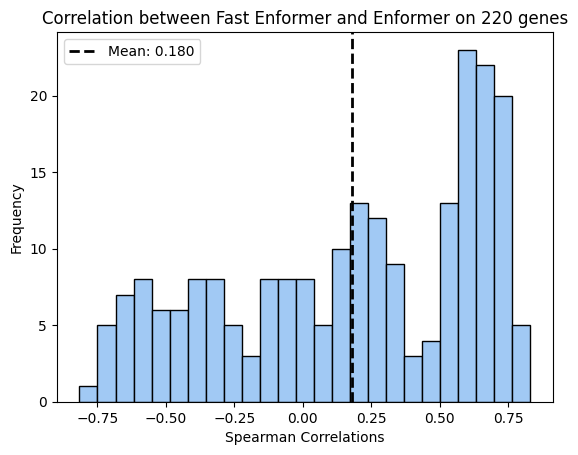

In [53]:
output_cors = pd.DataFrame(columns = ["r", "pval"], index = gene_list)
for gene in gene_list:
    individuals = haplo_expr[gene].dropna().index
    corr, pval = stats.spearmanr(pred_expr.loc[individuals, gene].values, haplo_expr.loc[individuals, gene].values)
    output_cors.loc[gene] = [corr, pval]
# Plot a pearson_corr_by_gene["human"]histogram
plt.hist(output_cors["r"], bins=25, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title(f'Correlation between Fast Enformer and Enformer on {len(gene_list)} genes')
plt.xlabel('Spearman Correlations')
plt.ylabel('Frequency')
mean = np.mean(output_cors["r"])
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()

# Display the plot
plt.show()

### Evaluating Fast Enformer against ground truth

**Distribution of Spearman R, P-value**

To plot the performance of gene expression derived from fast Enformer (haplotype probabilities $\times$ founder epigenomes) compared to observed expression. 

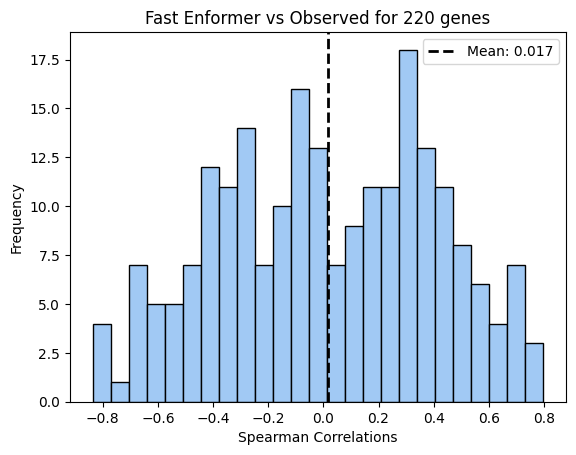

In [49]:
output_cors = pd.DataFrame(columns = ["r", "pval"], index = gene_list)
for gene in gene_list:
    individuals = haplo_expr[gene].dropna().index
    corr, pval = stats.spearmanr(obs_expr.loc[individuals, gene].values, haplo_expr.loc[individuals, gene].values)
    output_cors.loc[gene] = [corr, pval]
# Plot a pearson_corr_by_gene["human"]histogram
plt.hist(output_cors["r"], bins=25, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title(f'Correlation between Fast Enformer and Observed on {len(gene_list)} genes')
plt.xlabel('Spearman Correlations')
plt.ylabel('Frequency')
mean = np.mean(output_cors["r"])
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()

# Display the plot
plt.show()

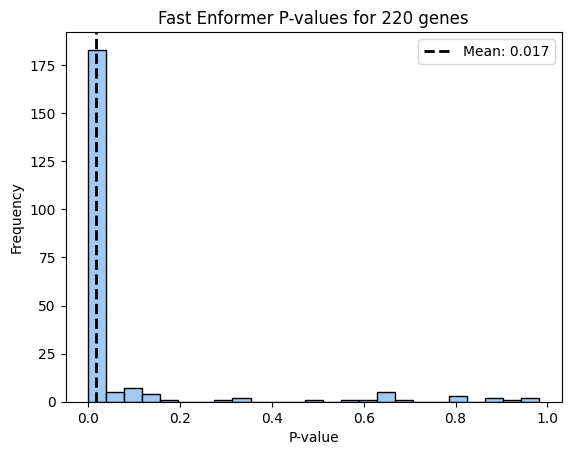

In [41]:
# Plot a pearson_corr_by_gene["human"]histogram
plt.hist(output_cors["pval"], bins=25, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title(f'Fast Enformer P-values for {len(gene_list)} genes')
plt.xlabel('P-value')
plt.ylabel('Frequency')
mean = np.mean(output_cors["r"])
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()

# Display the plot
plt.show()

**Comparing Gene Performance between Enformer and Fast Enformer**

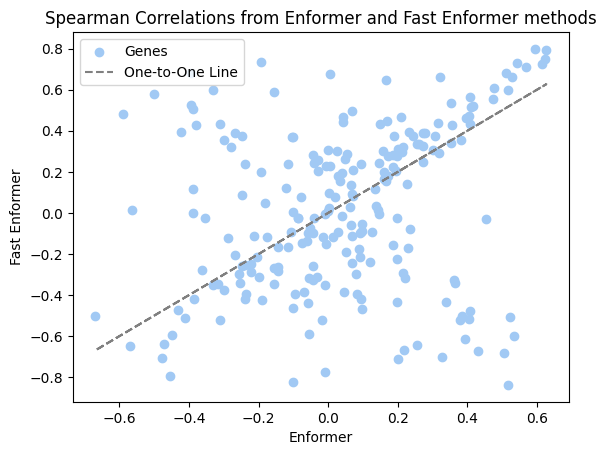

In [42]:
# Fit a linear regression line to the data (calculate slope)
x = cors["spearman r"].values.astype(np.float32)
y = output_cors["r"].values.astype(np.float32)
#  slope, intercept = np.polyfit(x, y, 1)
# Create the plot
plt.scatter(x, y, label='Genes', marker='o', color=colors[0])
# plt.plot(x, slope * x + intercept, '--', color="black", label=f'Best Fit Line: y = {slope:.3f}x + {intercept:.3f}')
plt.plot(x, x, '--', color="grey", label=f'One-to-One Line')
plt.title("Spearman Correlations from Enformer and Fast Enformer methods")
# Add labels and legend
plt.xlabel('Enformer')
plt.ylabel('Fast Enformer')
plt.legend()

# Show the plot
plt.show()

In [19]:
#| code-fold: true
def qqR(corvec, nn, title):
    # nn is the sample size, the number of individuals used to compute correlation
    # corvec is the correlation vector

    mm = len(corvec)
    nullcorvec = np.tanh(np.random.normal(size=mm) / np.sqrt(nn - 3))  # null correlation vector

    sm.qqplot_2samples(nullcorvec, corvec)
    plt.plot([0, 1], [0, 1], color='grey')  # Diagonal line
    plt.title(title)
    plt.grid()
    plt.show()

## Parsl Test

In [2]:
import parsl
from parsl.configs.htex_local import config
from parsl import python_app

parsl.load(config)

In [3]:
def interpolate(x, xi, y):
    j   =   tf.argsort(tf.concat((x, xi), axis=-1))
    k   =   tf.range(len(j))
    q   =   tf.scatter_nd(j[:, tf.newaxis], k, k.shape)

    lxi =   len(xi)

    r   =   q[-lxi:]-tf.range(0, lxi)
    r   =   tf.where(xi == x[-1], q[-1:] - lxi, r)

    x2  =   tf.gather(x, r)
    x1  =   tf.gather(x, r-1)
    y2  =   tf.gather(y, r)
    y1  =   tf.gather(y, r-1)

    u   =   (xi-x1)/(x2-x1)
    if not tf.rank(u) == tf.rank(y1):
        u   =   tf.expand_dims(u, axis=-1)

    yi  =   (1.0-u)*y1 + u*y2

    return tf.where(y1 == y2, y1, yi)

def compute_epigenome(reference_file, gene, start, end, prob):
    x = tf.constant(prob['POS'].values)
    y = tf.constant(prob.drop(columns=['POS']).values)
    bins = tf.linspace(start, end, 896)
    pr_tensor = tf.expand_dims(interpolate(x, bins, y), axis=1)
    with h5py.File(reference_file, "r") as hf:
        matrix = hf[gene][:]
    ref_tensor = tf.transpose(matrix, perm=[1, 0, 2])
    pr_tensor = tf.cast(pr_tensor, dtype=tf.float16)
    ref_tensor = tf.cast(ref_tensor, dtype=tf.float16)
    output = tf.squeeze(tf.matmul(pr_tensor, ref_tensor), axis=1)
    return output

def run_sample_predictions(prob, reference_file, gene_annot):
    predictions = []
    for index, row in gene_annot.iterrows():
        gene = row['gene']
        tss = row['tss']
        start = tss - 57344
        end = tss + 57344
        if (start >= prob.iloc[0,0] and end <= prob.iloc[-1,0]):
            output = compute_epigenome(reference_file, gene, start, end, prob)
            # Process genotype probabilities
            predictions.append(np.average(output[446:450]))
    return predictions

In [6]:

@python_app
def run_predictions(probabilities_file, reference_file, group, individuals, output_file, log_file, module_path = run_dir):
    import time
    import h5py
    import pandas as pd

    import sys
    sys.path.append(module_path)
    from tensor_helpers import run_sample_predictions
    
    start_time = time.perf_counter()
    haplo_expr = pd.DataFrame(columns=group['gene'], index=individuals)
    f = open(log_file, "w")
    with h5py.File(probabilities_file, "r") as input:
        for individual in individuals:
            tic = time.perf_counter()
            columns = ['POS', 'ACI', 'BN', 'BUF', 'F344', 'M520', 'MR', 'WKY', 'WN']
            prob = pd.DataFrame(input[individual][:], columns=columns)
            predictions = run_sample_predictions(prob, reference_file, group)
            haplo_expr.loc[individual] = predictions
            toc = time.perf_counter()
            f.write(individual, "...", toc - tic, "sec\n")
    end_time = time.perf_counter()
    haplo_expr.to_csv(output_file)
    f.write('Completed job in', (end_time - start_time) / 60 ,'minutes.')
    f.close()
    return haplo_expr

In [9]:
app_futures = []
for chr, group in genes_df.groupby("chromosome"):
    reference_file = os.path.join(reference_dir, f"{chr}_genes.h5")
    probabilities_file = os.path.join(probabilities_dir, f"{chr}_probabilities.h5")
    output_file = os.path.join(output_dir, f"{chr}_selected_genes.csv")
    log_file = os.path.join(output_dir, f"{chr}_selected_genes.log")
    app_futures.append(run_predictions(probabilities_file, reference_file, group, individuals, output_file, log_file, module_path = run_dir))

exec_futures = [q.result() for q in app_futures]

In [10]:
reference_file = os.path.join(reference_dir, f"{chr}_genes.h5")
probabilities_file = os.path.join(probabilities_dir, f"{chr}_probabilities.h5")
individuals = pred_expr.index

In [23]:
import tensorflow as tf
def interpolate(x, xi, y):
    j   =   tf.argsort(tf.concat((x, xi), axis=-1))
    k   =   tf.range(len(j))
    q   =   tf.scatter_nd(j[:, tf.newaxis], k, k.shape)

    lxi =   len(xi)

    r   =   q[-lxi:]-tf.range(0, lxi)
    r   =   tf.where(xi == x[-1], q[-1:] - lxi, r)

    x2  =   tf.gather(x, r)
    x1  =   tf.gather(x, r-1)
    y2  =   tf.gather(y, r)
    y1  =   tf.gather(y, r-1)

    u   =   (xi-x1)/(x2-x1)
    if not tf.rank(u) == tf.rank(y1):
        u   =   tf.expand_dims(u, axis=-1)

    yi  =   (1.0-u)*y1 + u*y2

    return tf.where(y1 == y2, y1, yi)

def compute_epigenome(reference_file, gene, start, end, prob):
    x = tf.constant(prob['POS'].values)
    y = tf.constant(prob.drop(columns=['POS']).values)
    bins = tf.linspace(start, end, 896)
    pr_tensor = tf.expand_dims(tf.cast(interpolate(x, bins, y), dtype=tf.float32), axis=1)
    with h5py.File(reference_file, "r") as hf:
        matrix = hf[gene][:]
    ref_tensor = tf.transpose(matrix, perm=[1, 0, 2])
    output = tf.squeeze(tf.matmul(pr_tensor, ref_tensor), axis=1)
    return output

def run_sample_predictions(prob, reference_file, gene_annot):
    predictions = []
    for index, row in gene_annot.iterrows():
        gene = row['gene']
        tss = row['tss']
        start = tss - 57344
        end = tss + 57344
        if (start >= prob.iloc[0,0] and end <= prob.iloc[-1,0]):
            output = compute_epigenome(reference_file, gene, start, end, prob)
            # Process genotype probabilities
            predictions.append(np.average(output[446:450]))
    return predictions

In [25]:
haplo_expr = pd.DataFrame(columns=group['gene'], index=individuals)
with h5py.File(probabilities_file, "r") as input:
    for individual in individuals:
        tic = time.perf_counter()
        columns = ['POS', 'ACI', 'BN', 'BUF', 'F344', 'M520', 'MR', 'WKY', 'WN']
        prob = pd.DataFrame(input[individual][:], columns=columns)
        predictions = run_sample_predictions(prob, reference_file, group)
        haplo_expr.loc[individual] = predictions
        toc = time.perf_counter()
        print(individual, "...", toc - tic, "sec")
        break

000789972A ... 13.396942946012132 sec
